## Assignment 2 — Reinforcement Learning for Battery Control  
### *Model-Based MDP Formulation & Optimal Policy Simulation*

---

This notebook walks through the entire pipeline:

1. Reading and cleaning price data  
2. Discretizing prices into quantile-based bins  
3. Learning a price transition matrix  
4. Building the MDP state and action spaces  
5. Constructing the transition kernel  
6. Defining the reward function  
7. Solving the MDP with **value iteration**  
8. Simulating the optimal policy on the test dataset  
9. Visualizing SOC, actions, profit, and cumulative revenue  

---

### Step 1 — Read Files and Inputs

We begin by loading the DK electricity price data from `Price.xlsx`.  
We perform:

- Timestamp conversion  
- Grouping by hour and bidding zone  
- Pivoting the data into a time-indexed price table  
- Filling missing values  
- Choosing the price area (DK2)  
- Creating a chronological **train/test split** (80%/20%)

The output of this step is a clean hourly time series  
$$
\lambda_t \in \mathbb{R}
$$
for use in price discretization and transition estimation.

---

### Step 2 — Train/Test Split

We split the dataset chronologically:

- Training set: first 80% of samples  
- Test set: last 20% of samples  

This avoids **future→past leakage**, which is important for time-series learning.

Let $T$ be the number of total hours.  
Then the train size is  

$$
T_{\text{train}} = \lfloor 0.8T \rfloor.
$$

---

### Step 3 — Price Discretization (Quantile Binning)

Because electricity prices are continuous, but an MDP requires discrete states,  
we discretize them into **5 quantile bins**:

$$
b_t = \text{Bin}(\lambda_t), \quad b_t \in \{0,1,2,3,4\}.
$$

Quantile binning ensures:

- Balanced representation of price regimes  
- Robustness to outliers  
- Smooth transitions for the Markov model  

We also compute **representative prices**:

$$
\bar{\lambda}_k = \mathbb{E}[\lambda_t \mid b_t = k].
$$

These are later used in the reward function.

---

### Step 4 — Price Transition Matrix

Using the price bins, we estimate the Markov transition matrix

$$
P_{ij} = \mathbb{P}(b_{t+1}=j \mid b_t = i)
$$

which is a $5 \times 5$ stochastic matrix where:

- Every row sums to 1  
- $P$ captures the tendency of prices to remain stable or move to different bins  

This matrix governs the *stochastic part* of the environment.

---

### Step 5 — MDP State Space

A state is defined by:

- State of charge (SOC), discretized into  
  $$
  \text{SOC} \in \{0, 100, 200, 300, 400\}
  $$
- Price bin  
  $$
  b_t \in \{0,1,2,3,4\}
  $$

Thus the full state is:

$$
s = (\text{SOC}, b_t)
$$

and the total number of states is:

$$
|\mathcal{S}| = 5\ (\text{SOC levels})\ \times\ 5\ (\text{price bins}) = 25.
$$

---

### Step 6 — Action Space and Feasibility

We use three actions:

- $0$: Charge  
- $1$: Discharge  
- $2$: Idle  

Feasibility constraints:

- If SOC $= 0$, discharging is not possible  
- If SOC is full, charging is not possible  

We therefore build a list of **valid actions** for each of the 25 states.

---

#### Step 7 — Transition Kernel \(P_{s,a}(s')\)

The transition model combines:

#### **1. SOC Update (Deterministic)**

Charging:
$$
\text{SOC}_{t+1} = \min(\text{SOC}_t + 100,\ 400)
$$

Discharging:
$$
\text{SOC}_{t+1} = \max(\text{SOC}_t - 100,\ 0)
$$

Idle:
$$
\text{SOC}_{t+1} = \text{SOC}_t
$$

#### **2. Price Update (Stochastic)**  
Derived directly from the learned price Markov chain:

$$
\mathbb{P}(b_{t+1} = j \mid b_t = i) = P_{ij}.
$$

Thus, the full transition probability is:

$$
P_{s,a}(s') =
\begin{cases}
P_{b,b'} & \text{if the SOC transition matches } a \\
0 & \text{otherwise}
\end{cases}
$$

This creates a **25 × 3 × 25** transition tensor.

---

### Step 8 — Reward Function

Rewards reflect expected profit from the chosen action.

Charging is costly:
$$
R(s,0) = -\bar{\lambda}_{b} \cdot P_{\max}
$$

Discharging yields revenue:
$$
R(s,1) = +\bar{\lambda}_{b} \cdot P_{\max}
$$

Idle gives no reward:
$$
R(s,2) = 0
$$

with:

- $P_{\max} = 100$ MWh    

This creates a reward matrix $R(s,a)$.

---

### Step 9 — Value Iteration (Solving the MDP)

Value iteration solves:

$$
V^{(k+1)}(s) = 
\max_{a \in A(s)} 
\left[
R(s,a) + \gamma \sum_{s'} P_{s,a}(s') V^{(k)}(s')
\right]
$$

We use:

- Discount factor $\gamma = 0.99$  
- Convergence tolerance $\epsilon = 10^{-6}$  

Value iteration returns the optimal value function:

$$
V^*(s)
$$

---

### Step 10 — Extract Optimal Policy

Once $V^*$ is found, we compute the optimal policy:

$$
\pi^*(s) = \arg\max_{a \in A(s)} 
\left[
R(s,a) + \gamma \sum_{s'} P_{s,a}(s') V^*(s')
\right]
$$

This policy maps each of the 25 states to one action:

- Charge  
- Discharge  
- Idle  

We visualize $\pi^*$ as a **heatmap** over:

- Rows: SOC  
- Columns: price bins  

This allows intuitive inspection of the learned strategy.

---

### Step 11 — Simulation on the Test Set

To evaluate the learned policy, we simulate over the test price series.

At each hour:

1. Identify current state $(\text{SOC}, b_t)$  
2. Apply optimal action $\pi^*(s)$  
3. Enforce feasibility  
4. Compute hourly profit  
5. Update SOC  
6. Move to next price bin  

Profit for hour $t$ under action $a_t$:

Charging:
$$
\Pi_t = -\lambda_t P_{\max}
$$

Discharging:
$$
\Pi_t = +\lambda_t P_{\max}
$$

Idle:
$$
\Pi_t = 0
$$

We store:

- Hourly SOC  
- Hourly action  
- Hourly profit  
- Cumulative profit  

This gives a realistic performance measure of the control strategy.

---

### Step 12 — Visualization of Simulation Results

We plot three time-series:

#### **1. SOC (State of Charge)**  
Shows how the battery cycles over time.

#### **2. RL Actions**  
Using:
- $0$: Charge  
- $1$: Discharge  
- $2$: Idle  

#### **3. Hourly Profit**  
Positive during discharge, negative during charge.

We also show:

#### **4. Cumulative Profit**

$$
\text{CumProfit}(t) = \sum_{\tau=1}^t \Pi_\tau
$$

This reveals long-term profitability of the RL-based strategy.

---

### Conclusion

This assignment demonstrated how to formulate and solve a **battery arbitrage problem** using reinforcement learning concepts:

- Historical prices → Quantile bins  
- Quantile bins → Price transition matrix  
- (SOC × PriceBin) → State space  
- Charge/Discharge/Idle → Action space  
- Learned $P$ + rewards → MDP  
- Value iteration → Optimal policy  
- Simulation → Realistic profit evaluation  

The resulting policy is a complete **optimal control strategy** for a battery participating in electricity markets.

It captures the stochastic nature of prices and makes long-term, profit-driven decisions using the MDP framework.

---


## Read files and inputs

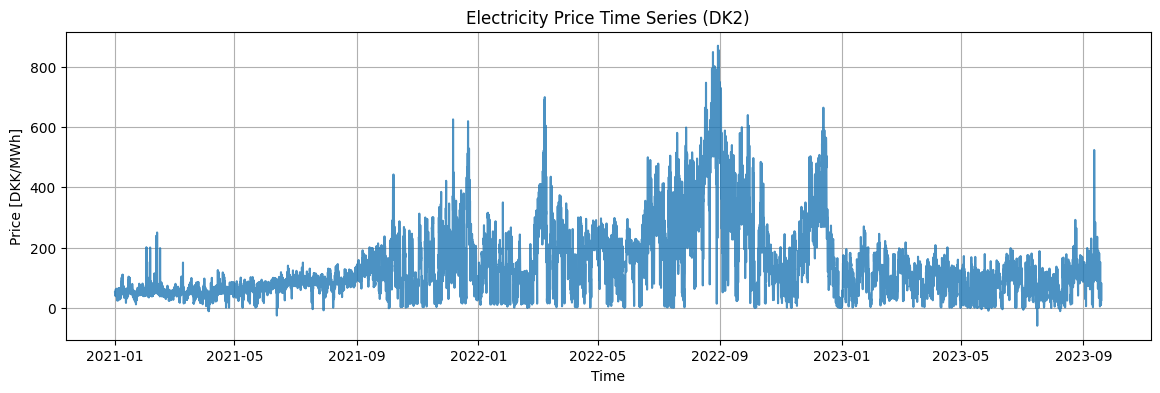

First 10 rows of the pivoted dataset:


PriceArea,DE,DK1,DK2,NO2,SE3,SE4,SYSTEM
HourDK,,,,,,,
2021-01-01 00:00:00,50.869999,50.869999,50.869999,24.950001,24.950001,24.950001,24.740000
2021-01-01 01:00:00,48.189999,48.189999,48.189999,24.350000,24.350000,24.350000,24.280001
2021-01-01 02:00:00,44.680000,44.680000,44.680000,23.980000,23.980000,23.980000,23.900000
2021-01-01 03:00:00,42.919998,42.919998,42.919998,23.719999,23.719999,23.719999,23.610001
2021-01-01 04:00:00,40.389999,40.389999,40.389999,23.730000,23.730000,23.730000,23.660000
2021-01-01 05:00:00,40.200001,40.200001,40.200001,24.059999,24.059999,24.059999,24.059999
2021-01-01 06:00:00,39.630001,39.630001,39.630001,24.440001,24.440001,24.440001,24.430000
2021-01-01 07:00:00,40.090000,40.090000,40.090000,24.930000,24.930000,24.930000,24.900000
2021-01-01 08:00:00,41.270000,41.270000,41.270000,24.900000,24.900000,24.900000,24.910000


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================
# STEP 1 — LOAD PRICE DATA
# ======================================================
df = pd.read_excel("Price.xlsx")
df["HourUTC"] = pd.to_datetime(df["HourUTC"])
df["HourDK"]  = pd.to_datetime(df["HourDK"])

df = df.groupby(["HourDK","PriceArea"], as_index=False).mean()
df = df.pivot(index="HourDK", columns="PriceArea", values="PriceEUR").sort_index()

# Fill missing values
df = df.ffill().bfill()

# Select price area (DK2 recommended)
price_area = "DK2"
prices = df[price_area].copy()
prices.name = "PriceDKK"

# --- VISUAL CHECK: Raw price time series ---
plt.figure(figsize=(14,4))
plt.plot(df.index, prices, alpha=0.8)
plt.title("Electricity Price Time Series (DK2)")
plt.ylabel("Price [DKK/MWh]")
plt.xlabel("Time")
plt.grid(True)
plt.show()

print("First 10 rows of the pivoted dataset:")
display(df.head(10))





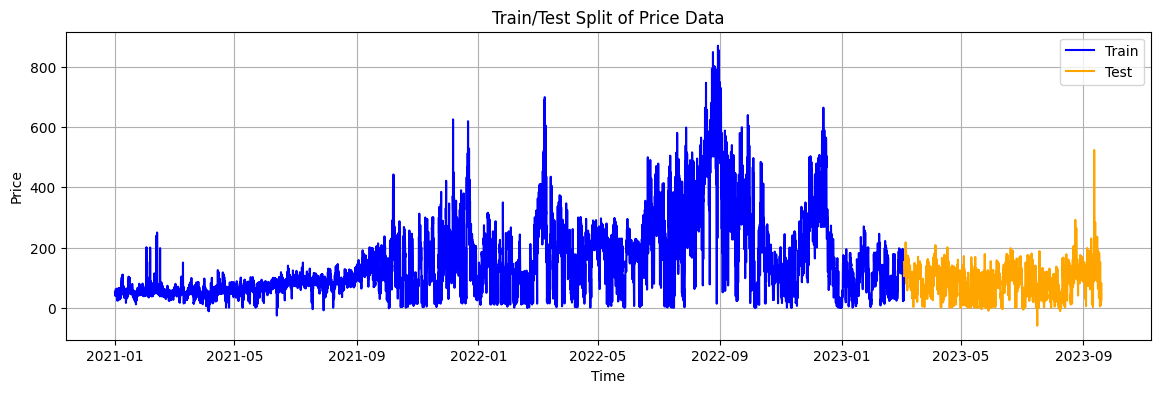

Training samples: 19024
Test samples: 4757


In [2]:
# ======================================================
# STEP 2 — TRAIN/TEST SPLIT
# ======================================================
T = len(prices)
train_size = int(0.8 * T)

prices_train = prices.iloc[:train_size]
prices_test  = prices.iloc[train_size:]

plt.figure(figsize=(14,4))
plt.plot(prices_train, label="Train", color="blue")
plt.plot(prices_test, label="Test", color="orange")
plt.title("Train/Test Split of Price Data")
plt.ylabel("Price")
plt.xlabel("Time")
plt.legend()
plt.grid(True)
plt.show()

print("Training samples:", len(prices_train))
print("Test samples:", len(prices_test))

## Building the problem on training data


--- PRICE BINS (Quantile-based) ---
Bin edges: [-61.040001  48.07      81.300003 134.809998 222.       872.      ]
Example of price → bin mapping:


,Price,Bin
HourDK,,
2021-01-01 00:00:00,50.869999,1
2021-01-01 01:00:00,48.189999,1
2021-01-01 02:00:00,44.680000,0
2021-01-01 03:00:00,42.919998,0
2021-01-01 04:00:00,40.389999,0
2021-01-01 05:00:00,40.200001,0
2021-01-01 06:00:00,39.630001,0
2021-01-01 07:00:00,40.090000,0
2021-01-01 08:00:00,41.270000,0


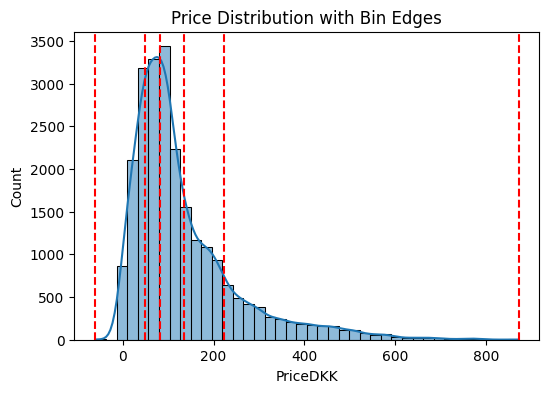

In [3]:
# ======================================================
# STEP 3 — PRICE DISCRETIZATION (5 bins)
# ======================================================
num_bins = 5

price_bins_train, bin_edges = pd.qcut(
    prices_train, 
    q=num_bins,
    labels=range(num_bins),
    retbins=True,
    duplicates="drop"
)

# Extend edges to cover full dataset
bin_edges[0]  = prices.min() - 1
bin_edges[-1] = prices.max() + 1

price_bins_full = pd.cut(
    prices,
    bins=bin_edges,
    labels=range(num_bins),
    include_lowest=True
).astype(int)

# Representative bin price
lambda_bar = np.array([
    prices_train[price_bins_train == b].mean() for b in range(num_bins)
])


print("\n--- PRICE BINS (Quantile-based) ---")
print("Bin edges:", bin_edges)
print("Example of price → bin mapping:")
display(pd.DataFrame({
    "Price": prices.head(20),
    "Bin": price_bins_full.head(20)
}))
    
# visualize distribution
plt.figure(figsize=(6,4))
sns.histplot(prices, bins=40, kde=True)
for be in bin_edges:
    plt.axvline(be, color="red", linestyle="--")
plt.title("Price Distribution with Bin Edges")
plt.show()

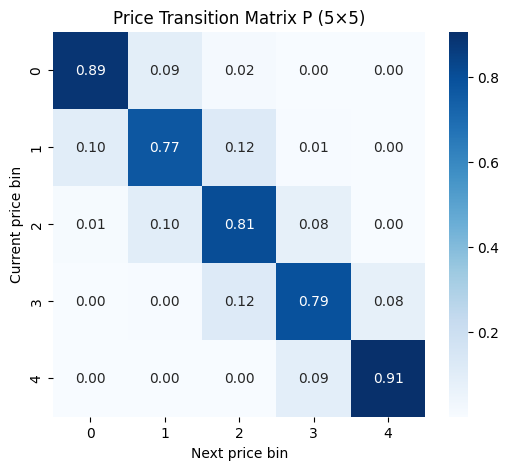

Rows sum to: [1. 1. 1. 1. 1.]


In [4]:
# ======================================================
# STEP 4 — PRICE TRANSITION MATRIX
# ======================================================
def compute_price_transition_matrix(price_bins):
    K = num_bins
    P = np.zeros((K, K))
    bins = price_bins.values

    for t in range(len(bins)-1):
        i = bins[t]
        j = bins[t+1]
        P[i,j] += 1

    # normalize rows
    P = (P.T / P.sum(axis=1)).T
    return P

price_P = compute_price_transition_matrix(price_bins_full)

plt.figure(figsize=(6,5))
sns.heatmap(price_P, annot=True, fmt=".2f", cmap="Blues")
plt.title("Price Transition Matrix P (5×5)")
plt.xlabel("Next price bin")
plt.ylabel("Current price bin")
plt.show()

print("Rows sum to:", price_P.sum(axis=1))

In [5]:
# ======================================================
# STEP 5 — STATE SPACE (SOC × Previous Price Bin)
# ======================================================

SOC_levels = np.array([0,100,200,300,400])  # true MWh
price_states = np.arange(num_bins)

# STATE = (SOC_t, price_bin_{t-1})
STATES = [(soc, pbin_prev) for soc in SOC_levels for pbin_prev in price_states]
state_to_idx = {s:i for i,s in enumerate(STATES)}
num_states = len(STATES)

print("\n--- STATE SPACE EXAMPLE ---")
print("Total number of states:", len(STATES))
print("First 10 states:")
for s in STATES[:10]:
    print(s)



--- STATE SPACE EXAMPLE ---
Total number of states: 25
First 10 states:
(np.int64(0), np.int64(0))
(np.int64(0), np.int64(1))
(np.int64(0), np.int64(2))
(np.int64(0), np.int64(3))
(np.int64(0), np.int64(4))
(np.int64(100), np.int64(0))
(np.int64(100), np.int64(1))
(np.int64(100), np.int64(2))
(np.int64(100), np.int64(3))
(np.int64(100), np.int64(4))


In [6]:
# ======================================================
# STEP 6 — VALID ACTIONS
# ======================================================
# Action indices: 0=Charge, 1=Discharge, 2=Idle
ACTIONS = np.array(["Charge","Discharge","Idle"])

def build_valid_actions(SOC_levels):
    valid = []
    for soc in SOC_levels:
        if soc == 0:
            valid.append([0,2])         # can charge, idle
        elif soc == SOC_levels[-1]:
            valid.append([1,2])         # can discharge, idle
        else:
            valid.append([0,1,2])       # all allowed
    return valid

valid_actions_SOC = build_valid_actions(SOC_levels)

# Expand over price bins
VALID_ACTIONS = []
for soc_idx, soc in enumerate(SOC_levels):
    for _ in price_states:
        VALID_ACTIONS.append(valid_actions_SOC[soc_idx].copy())

VALID_ACTIONS = np.array(VALID_ACTIONS, dtype=object)

print("\n--- VALID ACTIONS CHECK ---")
for i, soc in enumerate(SOC_levels):
    print(f"SOC {soc}: allowed actions → {valid_actions_SOC[i]}")


--- VALID ACTIONS CHECK ---
SOC 0: allowed actions → [0, 2]
SOC 100: allowed actions → [0, 1, 2]
SOC 200: allowed actions → [0, 1, 2]
SOC 300: allowed actions → [0, 1, 2]
SOC 400: allowed actions → [1, 2]


In [7]:

# ======================================================
# STEP 7 — TRANSITION MATRIX P_sa (SOC + Lagged Price transitions)
# ======================================================

def build_transition_matrix(STATES, price_P, SOC_levels):
    n_states = len(STATES)
    n_actions = 3
    max_soc = SOC_levels[-1]

    P_sa = np.zeros((n_states, n_actions, n_states))

    for s_idx, (soc, pbin_prev) in enumerate(STATES):

        for a in range(n_actions):

            if a not in VALID_ACTIONS[s_idx]:
                continue

            # SOC transition
            if a == 0:       # charge
                soc2 = min(soc + 100, max_soc)
            elif a == 1:     # discharge
                soc2 = max(soc - 100, 0)
            else:            # idle
                soc2 = soc

            # PRICE transition (from previous bin → current bin)
            for next_pbin in range(num_bins):
                prob = price_P[pbin_prev, next_pbin]

                s2 = (soc2, next_pbin)
                s2_idx = state_to_idx[s2]

                P_sa[s_idx, a, s2_idx] = prob

    return P_sa

P_sa = build_transition_matrix(STATES, price_P, SOC_levels)


example_state = state_to_idx[(100, 2)]

print("\n--- TRANSITIONS FROM STATE (SOC=100, PrevPriceBin=2) ---")
for a in VALID_ACTIONS[example_state]:
    nonzero = np.where(P_sa[example_state, a] > 0)[0]
    print(f"Action {ACTIONS[a]} → {len(nonzero)} possible next states")



--- TRANSITIONS FROM STATE (SOC=100, PrevPriceBin=2) ---
Action Charge → 5 possible next states
Action Discharge → 5 possible next states
Action Idle → 5 possible next states


In [8]:

# ======================================================
# STEP 8 — REWARD MATRIX
# ======================================================
def build_rewards(STATES, price_P, lambda_bar, Pmax=100):
    R = np.zeros((len(STATES), 3))

    for i,(soc,pbin) in enumerate(STATES):

        # expected future price
        expected_price = np.dot(price_P[pbin], lambda_bar)

        R[i,0] = -expected_price * Pmax                  # Charge
        R[i,1] =  expected_price * Pmax  # Discharge
        R[i,2] =  0                                     # Idle

    return R

REWARDS = build_rewards(STATES, price_P, lambda_bar)


In [9]:
# ======================================================
# MDP CLASS (Value Iteration + Policy Iteration)
# ======================================================
class BatteryProblem:

    def __init__(self, gamma, STATES, ACTIONS, P_sa, REWARDS, VALID_ACTIONS):
        self.gamma = gamma
        self.STATES = STATES
        self.ACTIONS = ACTIONS
        self.P_sa = P_sa
        self.REWARDS = REWARDS
        self.VALID_ACTIONS = VALID_ACTIONS

    # ---------- VALUE ITERATION ----------
    def value_iteration(self, eps=1e-6):
        n = len(self.STATES)
        V = np.zeros(n)

        while True:
            V_new = np.zeros(n)

            for s in range(n):

                q_vals = []
                for a in self.VALID_ACTIONS[s]:
                    q = self.REWARDS[s,a] + self.gamma * np.sum(self.P_sa[s,a,:] * V)
                    q_vals.append(q)

                V_new[s] = max(q_vals)

            if np.max(np.abs(V_new - V)) < eps:
                return V_new

            V = V_new.copy()

    # ---------- POLICY FROM VALUE ----------
    def policy_from_value(self, V):
        n = len(self.STATES)
        policy = np.zeros(n, dtype=int)

        for s in range(n):
            best_q = -1e18
            best_a = 0
            for a in self.VALID_ACTIONS[s]:
                q = self.REWARDS[s,a] + self.gamma*np.sum(self.P_sa[s,a,:] * V)
                if q > best_q:
                    best_q = q
                    best_a = a
            policy[s] = best_a

        return policy
    
    def value_iteration_with_tracking(self, eps=1e-6):
        n = len(self.STATES)
        V = np.zeros(n)
        history = []
        iteration = 0

        while True:
            V_new = np.zeros(n)
            for s in range(n):
                V_new[s] = max([
                    self.REWARDS[s,a] + self.gamma * np.sum(self.P_sa[s,a] * V)
                    for a in self.VALID_ACTIONS[s]
                ])

            history.append(np.max(np.abs(V_new - V)))
            
            if history[-1] < eps:
                return V_new, history
            
            V = V_new.copy()
            iteration += 1




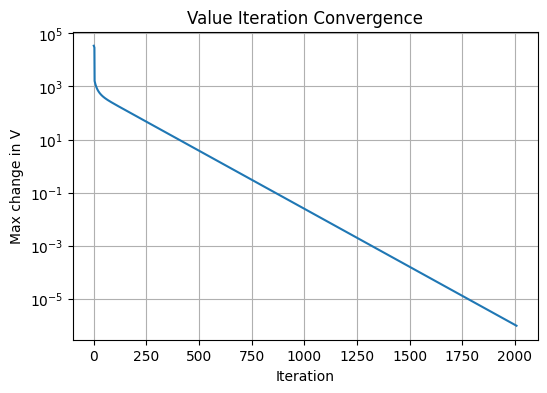

In [10]:
# ======================================================
# RUN MDP
# ======================================================
bp = BatteryProblem(
    gamma=0.99,
    STATES=STATES,
    ACTIONS=ACTIONS,
    P_sa=P_sa,
    REWARDS=REWARDS,
    VALID_ACTIONS=VALID_ACTIONS
)

V_opt = bp.value_iteration()
pi_opt = bp.policy_from_value(V_opt)


V_opt, history = bp.value_iteration_with_tracking()

plt.figure(figsize=(6,4))
plt.plot(history)
plt.title("Value Iteration Convergence")
plt.ylabel("Max change in V")
plt.xlabel("Iteration")
plt.yscale("log")
plt.grid(True)
plt.show()

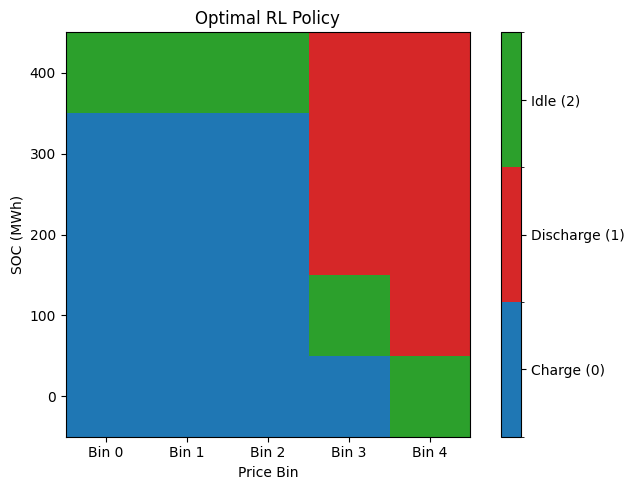

In [11]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import numpy as np


# ======================================================
# HEATMAP OF POLICY
# ======================================================
policy_grid = np.zeros((len(SOC_levels), num_bins))

for i, soc in enumerate(SOC_levels):
    for j in range(num_bins):
        state_idx = state_to_idx[(soc, j)]
        policy_grid[i,j] = pi_opt[state_idx]

# ======================================================
# DISCRETE (NON-GRADIENT) POLICY HEATMAP
# ======================================================

# Define discrete colormap
cmap = ListedColormap(["#1f77b4",   # blue = Charge (0)
                       "#d62728",   # red = Discharge (1)
                       "#2ca02c"])  # green = Idle (2)

# Boundaries: -0.5, 0.5, 1.5, 2.5  (centers at 0,1,2)
bounds = [-0.5, 0.5, 1.5, 2.5]
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(7,5))
plt.imshow(policy_grid, cmap=cmap, norm=norm, origin="lower")

cbar = plt.colorbar(ticks=[0,1,2])
cbar.ax.set_yticklabels(["Charge (0)", "Discharge (1)", "Idle (2)"])

plt.xticks(range(num_bins), [f"Bin {i}" for i in range(num_bins)])
plt.yticks(range(len(SOC_levels)), SOC_levels)

plt.title("Optimal RL Policy")
plt.xlabel("Price Bin")
plt.ylabel("SOC (MWh)")
plt.tight_layout()
plt.show()

## Evaluation of the Obtained Policy

In [12]:
# Build test dataframe
df_test = pd.DataFrame({
    "PriceDKK": prices_test,
    "price_bin": price_bins_full.loc[prices_test.index].values,
})

df_test["Hour"] = df_test.index
df_test = df_test.reset_index(drop=True)

df_test.head()

,PriceDKK,price_bin,Hour
0,151.660004,3,2023-03-04 18:00:00
1,143.789993,3,2023-03-04 19:00:00
2,122.989998,2,2023-03-04 20:00:00
3,114.879997,2,2023-03-04 21:00:00
4,112.529999,2,2023-03-04 22:00:00


In [13]:
# -------------------------------
# SIMULATION PARAMETERS
# -------------------------------
P_max = 100      # MWh per action step (consistent with SOC increments)
max_soc = SOC_levels[-1]
min_soc = SOC_levels[0]

soc = 0                       # Start empty
prev_pbin = df_test["price_bin"].iloc[0]   # initial price bin

profits = []
soc_hist = []
action_hist = []
price_hist = []

for t in range(len(df_test)):
    price = df_test["PriceDKK"].iloc[t]
    pbin = df_test["price_bin"].iloc[t]

    # determine state index
    s_idx = state_to_idx[(soc, prev_pbin)]
    action = pi_opt[s_idx]  # from optimal policy (0,1,2)

    # --- enforce feasibility manually ---
    if soc == min_soc and action == 1:  # discharge impossible
        action = 2  # idle
    if soc == max_soc and action == 0:  # charge impossible
        action = 2  # idle

    # Compute profit
    if action == 0:     # charge → negative profit
        profit_t = -price * P_max
    elif action == 1:   # discharge → positive profit
        profit_t = price * P_max
    else:
        profit_t = 0

    # Log
    profits.append(profit_t)
    soc_hist.append(soc)
    action_hist.append(action)
    price_hist.append(price)

    # Update SOC
    if action == 0:
        soc = min(soc + 100, max_soc)
    elif action == 1:
        soc = max(soc - 100, min_soc)

    prev_pbin = pbin  # update for next state


In [14]:
df_test_eval = df_test.copy()
df_test_eval["SOC"] = soc_hist
df_test_eval["Action"] = action_hist
df_test_eval["Profit"] = profits
df_test_eval["CumProfit"] = np.cumsum(profits)

df_test_eval.head()


,PriceDKK,price_bin,Hour,SOC,Action,Profit,CumProfit
0,151.660004,3,2023-03-04 18:00:00,0,0,-15166.0004,-15166.0004
1,143.789993,3,2023-03-04 19:00:00,100,2,0.0000,-15166.0004
2,122.989998,2,2023-03-04 20:00:00,100,2,0.0000,-15166.0004
3,114.879997,2,2023-03-04 21:00:00,100,0,-11487.9997,-26654.0001
4,112.529999,2,2023-03-04 22:00:00,200,0,-11252.9999,-37907.0000


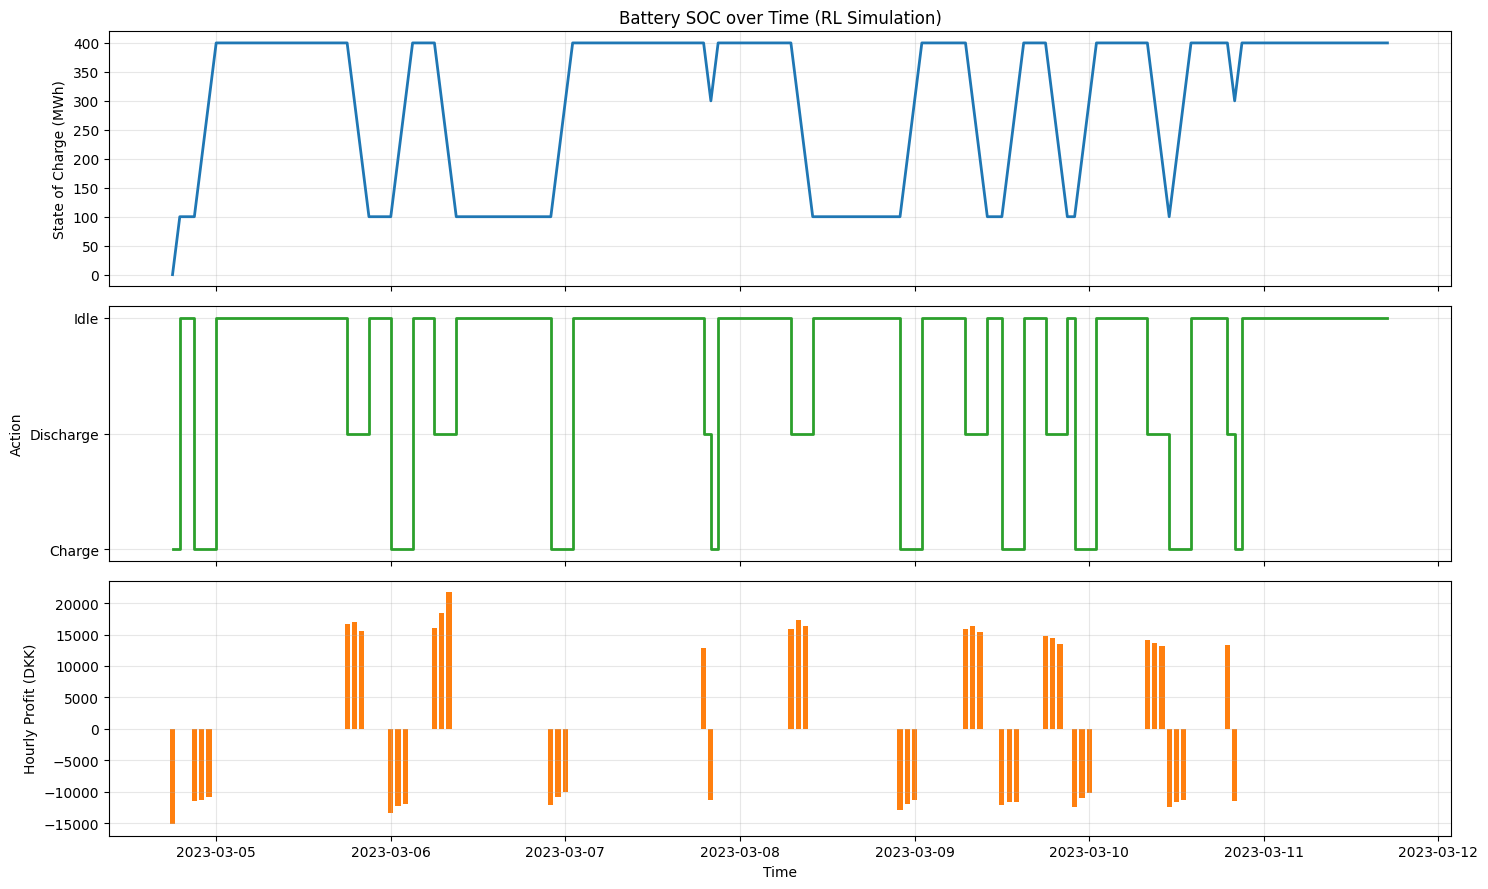

In [15]:
import matplotlib.dates as mdates

# Pick first week for easy inspection
subset = df_test_eval.iloc[:168]

time = pd.to_datetime(subset["Hour"])
soc = subset["SOC"]
actions = subset["Action"]
profits = subset["Profit"]

fig, axes = plt.subplots(3, 1, figsize=(15, 9), sharex=True)

# --- SOC ---
axes[0].plot(time, soc, linewidth=2, color="tab:blue")
axes[0].set_ylabel("State of Charge (MWh)")
axes[0].set_title("Battery SOC over Time (RL Simulation)")
axes[0].grid(True, alpha=0.3)

# --- Actions ---
axes[1].step(time, actions, where="post", linewidth=2, color="tab:green")
axes[1].set_ylabel("Action")
axes[1].set_yticks([0,1,2])
axes[1].set_yticklabels(["Charge", "Discharge", "Idle"])
axes[1].grid(True, alpha=0.3)

# --- Profit ---
axes[2].bar(time, profits, color="tab:orange", width=0.03)
axes[2].set_ylabel("Hourly Profit (DKK)")
axes[2].grid(True, alpha=0.3)

plt.xlabel("Time")
plt.tight_layout()
plt.show()


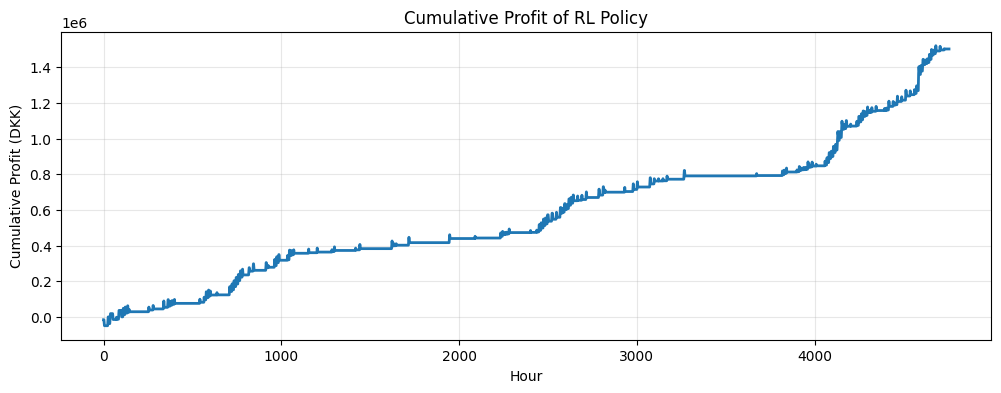

In [16]:
plt.figure(figsize=(12,4))
plt.plot(df_test_eval["CumProfit"], linewidth=2)
plt.title("Cumulative Profit of RL Policy")
plt.xlabel("Hour")
plt.ylabel("Cumulative Profit (DKK)")
plt.grid(True, alpha=0.3)
plt.show()
